# Hi :)

----

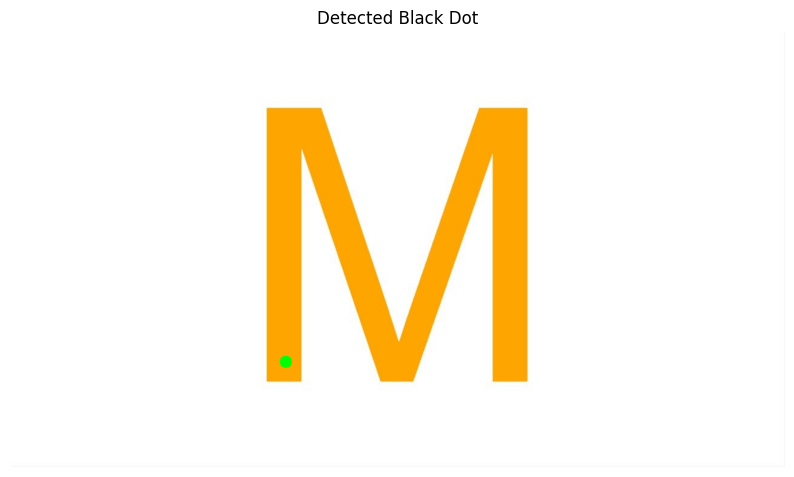

Black dot detected at coordinates: (455, 545)


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_black_dot(image_path):
    # Load the image
    image= cv2.imread(image_path)
    gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to detect dark areas
    _, binary= cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)  # Adjusted threshold for dark areas
    
    # Find contours
    contours, _= cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    detected_dot= None
    output_image= image.copy()
    
    for contour in contours:
        area= cv2.contourArea(contour)
        if 10 < area < 500:  # Filter small regions (10 < area < 500 is fine-tuned for the dot)
            # Compute the centroid of the contour
            M= cv2.moments(contour)
            if M["m00"] != 0:
                cx= int(M["m10"] / M["m00"])
                cy= int(M["m01"] / M["m00"])
                detected_dot= (cx, cy)
                # Mark the detected dot
                cv2.circle(output_image, (cx, cy), 10, (0, 255, 0), -1)
                break
    
    # Show the processed image with detected dot
    plt.figure(figsize= (10, 6))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Black Dot")
    plt.axis("off")
    plt.show()
    
    return detected_dot

# Provide the path to your image
image_path= "M.jpg"
black_dot_coordinates= detect_black_dot(image_path)

if black_dot_coordinates:
    print(f"Black dot detected at coordinates: {black_dot_coordinates}")
else:
    print("Black dot could not be detected.")

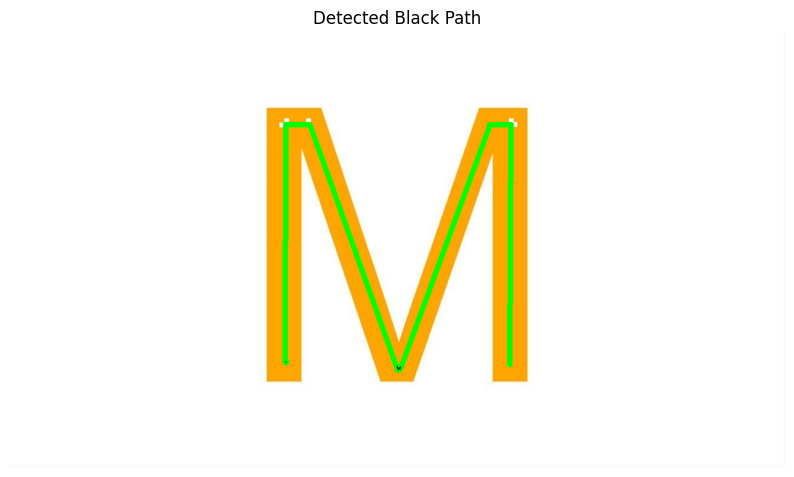

Black path detected.


In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_black_path(image_path):
    # Load the image
    image= cv2.imread(image_path)
    gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply a binary threshold to detect dark areas (black path)
    _, binary= cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)  # Adjust threshold for black
    # Remove noise using morphological operations
    kernel= np.ones((5, 5), np.uint8)
    binary_cleaned= cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    # Find contours
    contours, _= cv2.findContours(binary_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output_image= image.copy()
    detected_path= None
    for contour in contours:
        # Filter based on area (adjust thresholds as needed)
        area= cv2.contourArea(contour)
        if area > 500:  # Only consider large connected regions (the path)
            # Draw the detected path on the output image
            cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 3)
            detected_path= contour
    # Show the processed image with detected path
    plt.figure(figsize= (10, 6))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Black Path")
    plt.axis("off")
    plt.show()
    return detected_path
# Provide the path to your image
image_path= "M-Helper.jpg"
black_path= detect_black_path(image_path)
if black_path is not None:
    print("Black path detected.")
else:
    print("Black path could not be detected.")

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from moviepy.video.VideoClip import VideoClip
from PIL import Image, ImageDraw

def detect_black_path(image_path):
    # Load the image
    image= cv2.imread(image_path)
    gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply a binary threshold to detect dark areas (black path)
    _, binary= cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)
    # Remove noise using morphological operations
    kernel= np.ones((5, 5), np.uint8)
    binary_cleaned= cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    # Find contours
    contours, _= cv2.findContours(binary_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find the largest contour, assuming it's the path
    largest_contour= max(contours, key= cv2.contourArea) if contours else None
    return largest_contour
def animate_path(detection_image_path, draw_image_path, output_path, duration):
    # Step 1: Detect the path from the detection image
    path_contour= detect_black_path(detection_image_path)
    path_contour= path_contour[9 : -584]
    if path_contour is None:
        print("No path detected.")
        return
    # Approximate the path as a series of points
    path_points= path_contour[ : , 0, : ]  # Extract (x, y) coordinates from the contour
    # Step 2: Load the image for drawing
    draw_image= Image.open(draw_image_path).convert("RGB")
    base_frame= np.array(draw_image)
    # Step 3: Define the frame generation function
    def make_frame(t):
        # Copy the base image to avoid overwriting
        frame= base_frame.copy()
        img= Image.fromarray(frame)
        draw= ImageDraw.Draw(img)
        # Total time allocated to each segment of the path
        time_per_segment= duration / len(path_points)
        # Draw the path sequentially
        for i in range(1, len(path_points)):
            # Start and end times for the current segment
            segment_start_time= (i - 1) * time_per_segment
            segment_end_time= i * time_per_segment
            x1, y1= path_points[i - 1]
            x2, y2= path_points[i]
            # If we're within the time window for this segment
            if segment_start_time <= t < segment_end_time:
                # Compute the interpolation progress
                progress= (t - segment_start_time) / time_per_segment
                current_x= int(x1 + (x2 - x1) * progress)
                current_y= int(y1 + (y2 - y1) * progress)
                # Draw the partial path
                draw.line((x1, y1, current_x, current_y), fill= "red", width= 5)
                break
            # If we've passed the time for this segment, draw it fully
            elif t >= segment_end_time:
                draw.line((x1, y1, x2, y2), fill= "red", width= 5)
        # Return the frame as a NumPy array
        return np.array(img)
    # Step 4: Create the VideoClip using the frame function
    animation= VideoClip(make_frame, duration= duration)
    # Step 5: Write the animation to a video file
    animation.write_videofile(output_path, fps= 24)

# # Example usage
# detection_image= "M-Helper.jpg"  # Image to detect the path
# draw_image= "M.jpg"        # Image to draw on
# output_video= "M.mp4"          # Output video file
# animate_path(detection_image, draw_image, output_video, duration= 4)

In [7]:
detection_image= "M-Helper.jpg"  # Image to detect the path
draw_image= "M.jpg"        # Image to draw on
output_video= "M.mp4"          # Output video file
animate_path(detection_image, draw_image, output_video, duration= 8)

MoviePy - Building video M.mp4.
MoviePy - Writing video M.mp4



MoviePy - Done !
MoviePy - video ready M.mp4
